# ZephIR Demo

[https://github.com/venkatachalamlab/ZephIR](https://github.com/venkatachalamlab/ZephIR)

This notebook is a demo to illustrate a typical ZephIR workflow and is accompanied by a general [guide](https://github.com/venkatachalamlab/ZephIR/blob/main/docs/Guide-ZephIR.md) and [tutorial video](https://youtu.be/4O9aIftvoqM).

This notebook walks through the steps to analyze the provided short movie of semi-immobilized *C. elegans* with fluorescent IFT-20 expression. We will track the fluorescent neuron nuclei and extract their activity traces.

In [1]:
# Import ZephIR package
from zephir.main import *

# ZephIR is mostly run with terminal commands
# Subprocess library will be used to emulate this
import subprocess

In [2]:
# Define path to dataset directory
dataset = Path('__file__').parent.absolute() / 'data'

## Set up and preprocess dataset
To get the most of ZephIR, it is recommended that the data is preprocessed such that noise, photobleaching, and global translation & rotation are reduced. The demo dataset has reduced motion (global translation has been reduced by 50%), but no further preprocessing has been performed.


## Set up getters.py
Users attempting to work with data with different structures and IO bindings can copy and edit a `getters.py` file that consolidate key IO functions. The demo dataset is fully compatible with the default getters and does not require any further editing. Note that if the dataset directory is missing the getters file entirely, ZephIR will use the defaults.

## Annotate reference frames

ZephIR uses fully-annotated (all keypoints to be tracked are annotated) reference frames to seed the registration and tracking process. The built-in recommendation function uses k-medoids clustering to find N median frames that are most similar to most of the frames in the data. After determining the frames you want to use as reference frames, the included annotator GUI allows users to create annotations for those frames.

Run the following cells to create new annotations. Alternatively, to skip to the next step, copy the file `annotations-2.h5` in the backup folder into this folder and rename it to `annotations.h5`. This file contains annotations for the first recommended frame (plus one frame that includes a neuron that is not visible in the recommended frame).

In [3]:
# Determine the best frames to annotate as reference frames
subprocess.run(f'recommend_frames --dataset={dataset} --channel=1', shell=True)

CompletedProcess(args='recommend_frames --dataset=d:\\Public_repository\\ZephIR\\example\\data --channel=1', returncode=0)

In [5]:
f'recommend_frames --dataset={dataset} --channel=1'

'recommend_frames --dataset=d:\\Public_repository\\ZephIR\\example\\data --channel=1'

In [6]:
# Launch annotator to create annotations for reference frames
# Run this cell then open in a web browser: localhost:5001
subprocess.run(f'annotator --dataset={dataset} --port=5001', shell=True)

CompletedProcess(args='annotator --dataset=d:\\Public_repository\\ZephIR\\example\\data --port=5001', returncode=1)

## Run ZephIR

Run the following cell to run ZephIR with either the provided or the newly created annotations. ZephIR will use parameter and options outlined in `args.json`. Feel free to play with these parameters to test how they affect tracking quality.

ZephIR will create a movie annotated with the tracking results (`annotated.mp4`). This can be used to check results at a glance, but the annotator can be used for more detailed and careful verification of results. Any annotation with the provenance `ZEIR` is a tracking result automatically generated by ZephIR.

In [7]:
# Launch ZephIR to track keypoints as defined in fully-annotated reference frames
# User-tunable options are defined in the included args.json file

# Non-default arguments include:
# channel=1
# fovea_sigma=5.0
# grid_shape=35
# lambda_n=0.1
# lr_ceiling=0.06
# lr_floor=0.01
# z_compensator=4.0

subprocess.run(f'zephir --dataset={dataset} --load_args=True', shell=True)

CompletedProcess(args='zephir --dataset=d:\\Public_repository\\ZephIR\\example\\data --load_args=True', returncode=1)

## Verify results and correct errors

Launch the annotator for a detailed and careful verification of ZephIR tracking results.

Fix badly tracked frames by:

1. Verify a few correct tracking results by changing their provenance from `ZEIR` to another (`ANTT` by default). The macro `change_provenance` can do this efficiently.
2. Delete a few incorrect tracking results and insert new annotations for those keypoint at the correct locations.
3. Run the macro `update_frame` from the annotator GUI to run ZephIR for any remaining keypoints in the frame. It will use both verified correct results and fixed incorrect ones to improve tracking quality for the rest of the keypoints.

Alternatively, to skip to the next step, copy the file `annotations-g.h5` in the backup folder into this folder and rename it to `annotations.h5`. This file contains annotations for the first recommended frame, one frame including a neuron that is not visible in the recommended frame, partial annotations for a badly tracked frame (t=23), and ZephIR results for the rest. Note that adding partial annotations for the badly tracked frame not only fixes the remaining neurons in that frame, but results in all its child frames as well.

In [8]:
# Launch annotator to verify results and correct errors
# Run this cell then open in a web browser: localhost:5001
subprocess.run(f'annotator --dataset={dataset} --port=5001', shell=True)

CompletedProcess(args='annotator --dataset=d:\\Public_repository\\ZephIR\\example\\data --port=5001', returncode=1)

## Extract neuronal activity traces

Run the following cell to extract traces of neuronal activity. Neuronal activity, expressed as fluorescent intensity in the confocal microscopy recording, is calculated as the average of 9 maximal pixel intensities in a 3x7x7 crop around the tracked coordinates in each frame (after masking out any neighboring neurons that may end up in the crop). Traces extracted using tracking results in `annotations-g.h5` in the backup folder is also available in the backup folder as `traces.png`.

In [9]:
# Launch trace extraction to extract fluorescence intensity using tracked centers
subprocess.run(f'extract_traces --dataset={dataset} --channel=1', shell=True)

CompletedProcess(args='extract_traces --dataset=d:\\Public_repository\\ZephIR\\example\\data --channel=1', returncode=1)

In [12]:
Path('__file__').parent.absolute() / 'data' / 'backup' / 'traces.npy'

WindowsPath('d:/Public_repository/ZephIR/example/data/backup/traces.npy')

In [14]:
traces = np.load(Path('__file__').parent.absolute() / 'data' / 'backup' / 'traces.npy')

In [17]:
traces_2D = traces[0,0:22,:]

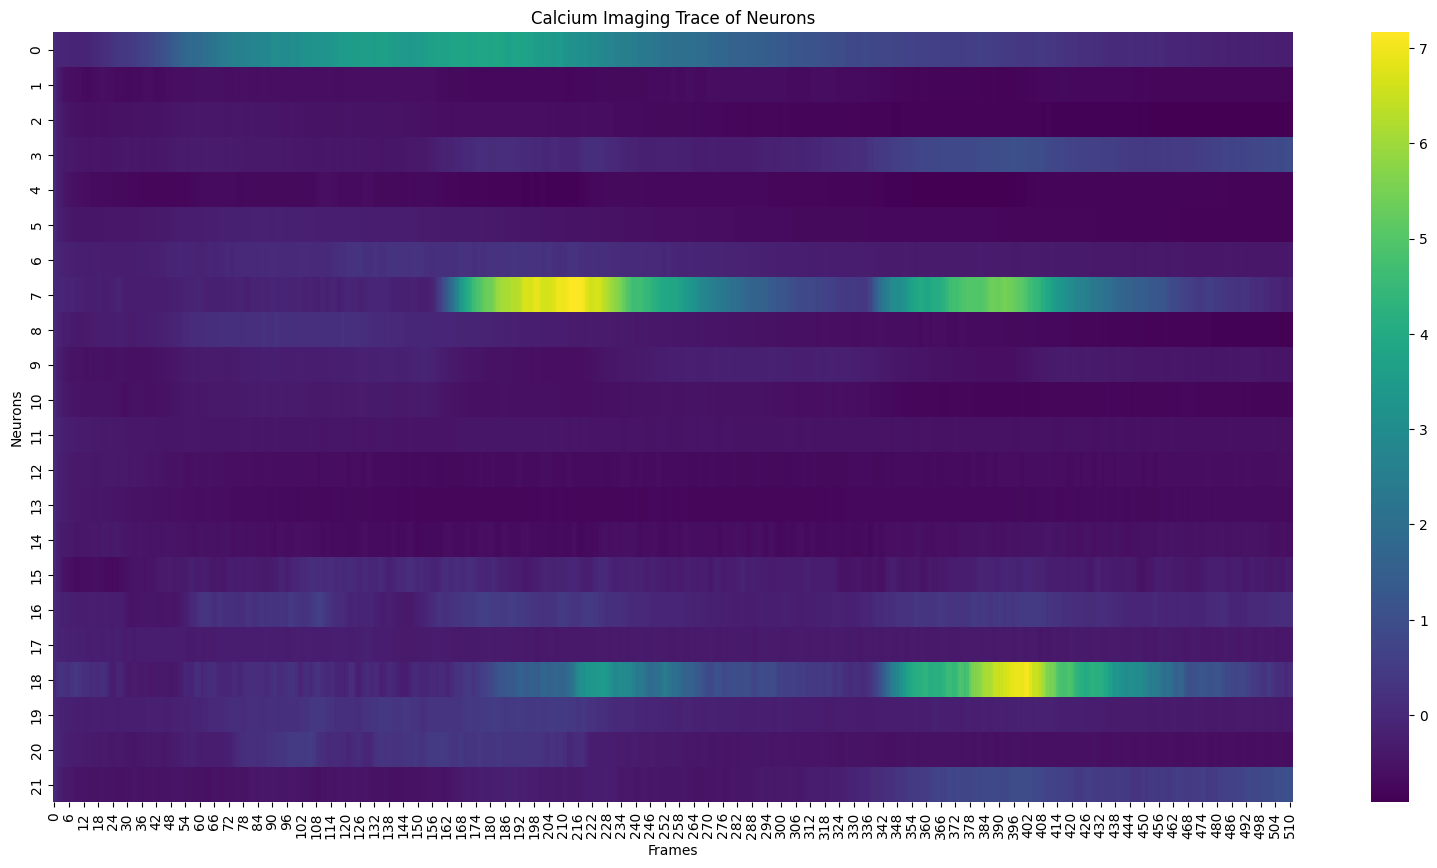

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'data' is your 23x512 ndarray
data = traces_2D  # Replace with your actual data

plt.figure(figsize=(20, 10))
sns.heatmap(data, cmap="viridis")
plt.xlabel("Frames")
plt.ylabel("Neurons")
plt.title("Calcium Imaging Trace of Neurons")
plt.show()

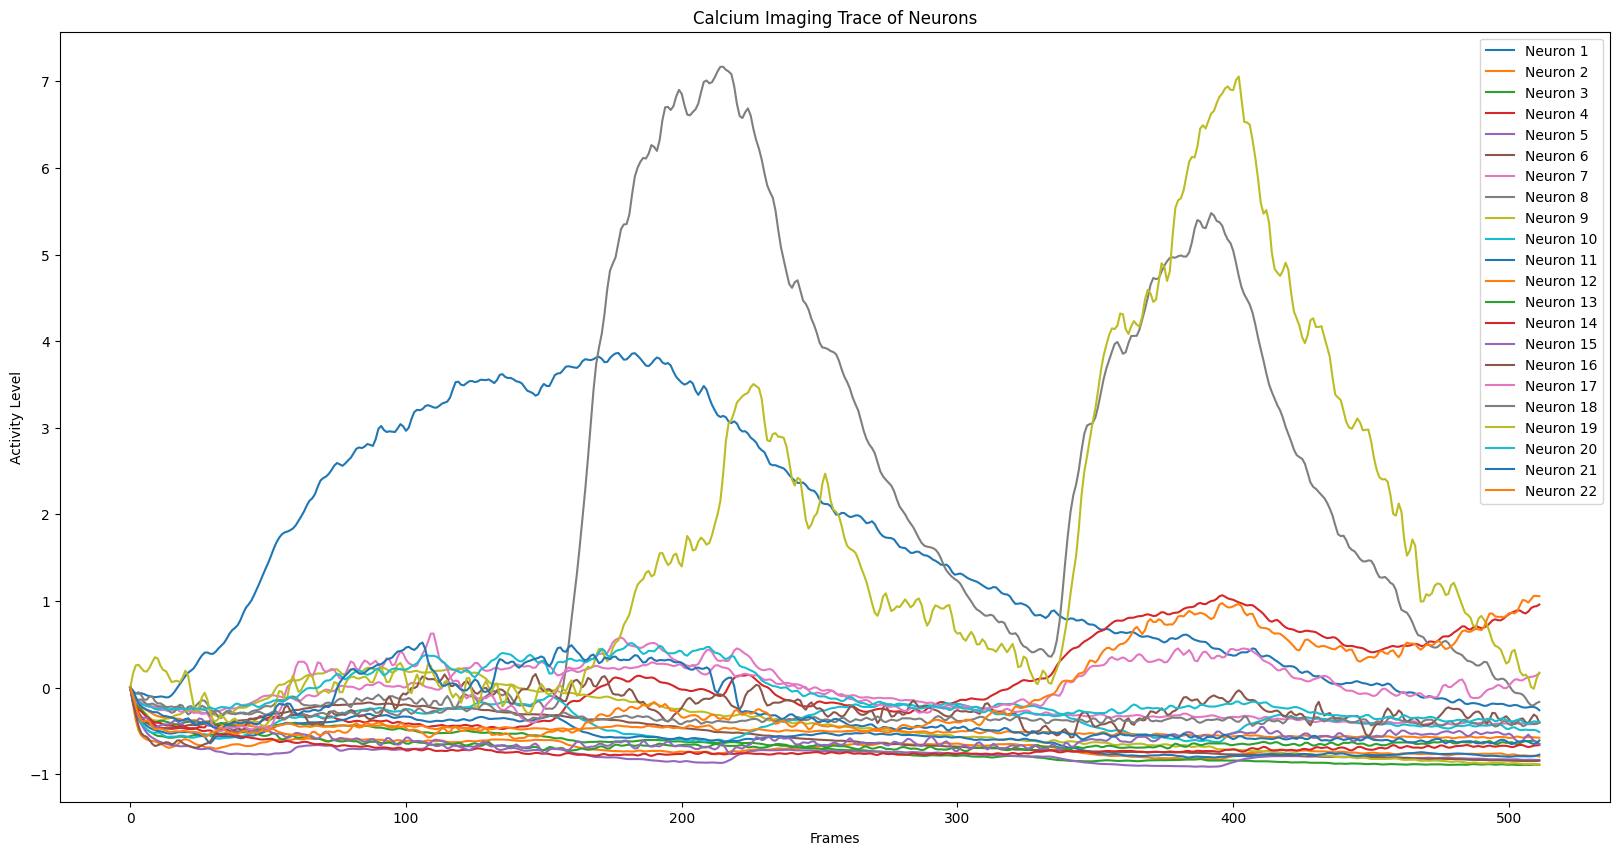

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your 23x512 ndarray
data = traces_2D  # Replace with your actual data

plt.figure(figsize=(20, 10))
for i in range(data.shape[0]):
    plt.plot(data[i], label=f'Neuron {i+1}')

plt.xlabel("Frames")
plt.ylabel("Activity Level")
plt.title("Calcium Imaging Trace of Neurons")
plt.legend()
plt.show()